In [1]:
import numpy as np
from sklearn.datasets import make_blobs
from umap import UMAP
import anndata
import seaborn as sns
import grinch as gr
from grinch.utils.ops import group_indices
import matplotlib.pyplot as plt

from src.truffle import Truffle

# Generate a simulated dataset

In [2]:
X, y = make_blobs(
    n_samples=500,
    n_features=15,
    centers=6,
    cluster_std=7,
    random_state=42,
)

# Plot

In [3]:
umap = UMAP(random_state=42, n_jobs=1)
x_2d = umap.fit_transform(X)

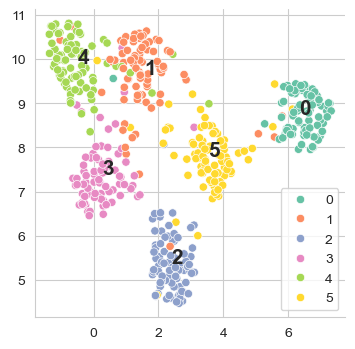

In [24]:
fig, ax = plt.subplots(figsize=(4, 4))
sns.scatterplot(x=x_2d[:, 0], y=x_2d[:, 1], hue=y, palette='Set2', ax=ax)
sns.despine(ax=ax)
items, groups = group_indices(y)
for item, group in zip(items, groups):
    x1 = x_2d[group, 0].mean()
    x2 = x_2d[group, 1].mean()
    ax.text(x1, x2, item, fontsize=15, weight='bold')
    
plt.savefig('../figs/simulation/UMAP.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

# Construct simulated visits

In [5]:
# random smooth paths

true_trajectories = [
    [0, 5, 1, 4],
    [5, 1, 3, 4],
    [4, 3, 1, 2, 5]
]

In [6]:
adata = anndata.AnnData(X)
adata.obs['y'] = y

In [7]:
# construct neighbors graph

gr.FuzzySimplicialSetGraph.Config(
    x_key='X',
    n_neighbors=10,
).create()(adata)

In [8]:
def add_subjects(X, y, true_trajectories, n_subjects: int = 80):
    """Adds random subjects from true trajectories"""
    rng = np.random.default_rng(seed=42)
    
    n_trajectories = len(true_trajectories)
    
    # map state to set of nodes
    state_nodes = dict(zip(*group_indices(y)))
    state_nodes = {state: set(nodes) for state, nodes in state_nodes.items()}
    
    subject_idx = np.full(len(X), -1)
    visit_idx = np.full(len(X), -1)
    
    for patient_idx in range(n_subjects):
        # pick random trajectory
        traj = true_trajectories[rng.choice(len(true_trajectories))]
        # delete random inner state
        state_to_delete = rng.choice(len(traj))
        # state_to_delete = rng.choice(np.arange(1, len(traj) - 1))
        traj = np.delete(traj, state_to_delete)
        
        # add connections
        for visit, state in enumerate(traj):
            # pick random node from this state
            node = rng.choice(list(state_nodes[state]))
            # remove node so that it is not used twice
            state_nodes[state].remove(node)
            # assign this patient to this node
            subject_idx[node] = patient_idx
            visit_idx[node] = visit

    singletons = subject_idx == -1
    # assign random ids to patients with one time point
    subject_idx[singletons] = np.arange(singletons.sum()) + subject_idx.max() + 1
    visit_idx[singletons] = 0  # these wont be used
    return subject_idx, visit_idx

In [9]:
subject_idx, visit_idx = add_subjects(X, y, true_trajectories)

In [10]:
adata.obs['subj'] = subject_idx
adata.obs['visit'] = visit_idx
adata.uns['visit_order'] = np.unique(visit_idx)

# Run Truffle

In [11]:
truffle = Truffle(max_path_len=4)

truffle.prepare(
    adata,
    adj='umap_distance',
    subject_id='subj',
    time_point='visit',
    time_point_order='visit_order',
)

INFO: Graph has a total of 6614 directed edges.
INFO: Found a total of 188 commodities across 312 subjects and 4 timepoints.
INFO: Found no path of len <= 4 from 44 to 24.
INFO: Minimal path length for all src to reach trg: 4
INFO: Found 1 infeasible commodities.
INFO: Using max_path_len=4


In [12]:
truffle.fit(edge_capacity=1, node_capacity=None)

Initialized 500 nodes.
Initialized 6614 edges.
Begin optimization.


INFO: 
Problem: 
- Name: unknown
  Lower bound: 16014.9493141174
  Upper bound: 16014.9493141174
  Number of objectives: 1
  Number of constraints: 11205
  Number of variables: 14680
  Number of nonzeros: 44040
  Sense: minimize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 1
      Number of created subproblems: 1
  Error rc: 0
  Time: 0.8433167934417725
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



# Analysis

In [13]:
out = truffle.get_state_diagram(adata, cluster='y')

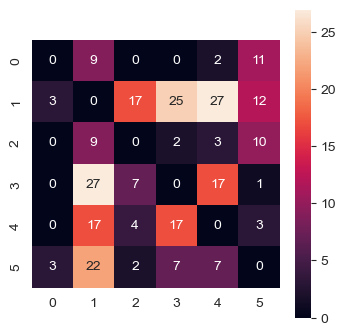

In [26]:
fig, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(out['state_diagram'], annot=True, square=True, ax=ax)

plt.savefig('../figs/simulation/state_diagram.pdf', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

In [15]:
top_paths = truffle.get_top_paths(
    out['state_diagram'],
    out['initial_states'],
    out['final_states'],
)

In [20]:
paths = []
# top 2 trajectories of length 3
paths.extend([p[0] for p in top_paths.most_common() if 5 > len(p[0]) >= 4][:3])
# top trajectory of length 4
paths.extend([p[0] for p in top_paths.most_common() if 6 > len(p[0]) >= 5][:1])

In [21]:
print(f"True trajectories: {true_trajectories}")
print(f"Predicted trajectories: {paths}")

True trajectories: [[0, 5, 1, 4], [5, 1, 3, 4], [4, 3, 1, 2, 5]]
Predicted trajectories: [(5, 1, 3, 4), (5, 1, 4, 3), (0, 5, 1, 4), (4, 3, 1, 2, 5)]
